# Predicting Time Use
### Jonathan Jensen and Robert Wagner
One of the fundamental questions of economics regards how people choose to spend their time. Many macroeconomic models deal with the labor/leisure decision and how that decision affects overall production in an economy. Many of the social sciences are concerned with how long people sleep, how long they spend with family members, and how much time they spend at work.

We use data from the American Time Use Survey (ATUS), a survey given out by the Bureau of Labor Statistics. It surveys roughly 15,000 individuals a year, collecting demographic information, information about family structure, and a detailed report about how the respondent spent each minute of each day.

The fundamental questions are as follows: how much of an individual's time use can be explained by outside factors? In other words, how well can an individual's time use be predicted based on their demographics and family structure? As we answer this question, we will discover which of these traits are strongest predictors of time use, and hopefully gain some insight into why people choose to do what they do. We focus on sleep because sleep alone provides us ample work to model.

Recent papers have shown that the aggregate amount people sleep has changed over this last recession. We also perform analysis to gain greater insight into the reasons why this amount changed. Did certain types of people sleep less while others slept the same amount? Do these predictive factors for sleep change over the business cycle? These questions are extremely relevant for public policy and help us to understand why people choose to act they way that they do.

We first read in the data, categorize time use, drop redundant variables, then visualize the relationships we are interested in. Then, we will proceed with our predictive analysis.

# Preparing the Data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_stata('atus0316.dta')
data.describe()

,tulineno,tespuhrs,trdtind1,trernhly,trnumhou,trtalone,trtcc,trthhfamily,trtnochild,trtnohh,...,prernwa,prtage,prunedur,ptnmemp1,ptnmemp2,puhroff2,puhrot2,pulineno,tubwgt,nvals
count,181335.0,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,...,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.000000,181335.0
mean,1.0,13.533106,19.081915,486.959442,2.767375,308.660027,126.275540,272.659272,56.200160,8.549464,...,36084.816594,41.691207,-0.184167,-0.981471,-0.999537,-0.325271,-0.597772,1.922045,11694.961914,1.0
std,0.0,21.486784,19.189209,908.230713,1.530201,264.239246,237.857237,290.263667,144.359952,67.954387,...,58155.866689,22.995085,7.140308,0.742586,0.059869,3.582052,2.447098,1.229094,7607.898926,0.0
min,1.0,-4.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-3.000000,-3.000000,1.000000,1931.161499,1.0
25%,1.0,-1.000000,-1.000000,-1.000000,2.000000,95.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,23.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,7456.697266,1.0
50%,1.0,-1.000000,21.000000,-1.000000,2.000000,240.000000,0.000000,190.000000,0.000000,0.000000,...,-1.000000,43.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,8780.768555,1.0
75%,1.0,40.000000,40.000000,850.000000,4.000000,470.000000,140.000000,494.000000,0.000000,0.000000,...,57692.000000,60.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,13762.958984,1.0
max,1.0,99.000000,51.000000,9999.000000,16.000000,1440.000000,1290.000000,1440.000000,1440.000000,1230.000000,...,288461.000000,85.000000,119.000000,75.000000,10.000000,99.000000,99.000000,15.000000,114032.093750,1.0


We have 541 columns as is. The ATUS gives very detailed information about activities. For now, let's summarize the activity codes. We will break things up into sleep, production, housework, and leisure. Production refers to anything related to school for students or any sort of wage-paying work. Housework refers to activites in a household that some people pay others to do - lawn care, childcare, meal preparation, etc. The varaible for housework will be called 'hwork' for brevity's sake.

The following function will allow me to aggregate sets of variables using only their prefixes. I will then aggregate time use data based on the previously mentioned 4 categories.

In [3]:
def column_grab(varlist, data): #Grabs every column in data that has an element of varlist in its name
    temp = []
    for item in varlist:
        temp = temp+[col for col in data.columns if item in col]
    return temp

In [4]:
sleeplist = ['t0101']
productionlist = ['t05', 't06', 't1805', 't1806']
hworklist = ['t02', 't03', 't04', 't07', 't08', 't09', 't10', 't160103', 't160104', 't160105', 't160106', 't160107', 't160108', 't169989', 't1802', 't1803', 't1804', 't1807', 't1808', 't1809', 't1810']
leisurelist = ['t0102', 't0103', 't0104', 't0105', 't019999', 't11', 't12', 't13', 't14', 't15', 't160101', 't160102', 't1801', 't1811', 't1812', 't1813', 't1814', 't1815', 't1816', 't1818', 't189999']
sleep_cols = column_grab(sleeplist, data)
production_cols = column_grab(productionlist, data)
hwork_cols = column_grab(hworklist, data)
leisure_cols = column_grab(leisurelist, data)
sleep = data[sleep_cols].sum(axis=1)
production = data[production_cols].sum(axis=1)
hwork = data[hwork_cols].sum(axis=1)
leisure = data[leisure_cols].sum(axis=1)
alltimevars = sleep_cols+production_cols+hwork_cols+leisure_cols
sleepdata = data[sleep_cols]
leisuredata = data[leisure_cols]
hworkdata = data[hwork_cols]
productiondata = data[production_cols]
data.drop(alltimevars, axis=1, inplace=True)

Let's finish cleaning the data. We first work with missing data, and then move on to creating dummy variables.

In [5]:
data.columns[data.isnull().any()]

Index([], dtype='object')

That's the best news I've heard all day. Let's make some dummies and label encode as needed.

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

There are a few very-detailed employment variables that we can drop right off the bat. They pertain to only a handful of respondents, and have to do with very specific information dealing with how one searched for a job after being unemployed a certain amount of time.

In [7]:
findempllist = column_grab(['pelkm', 'pulkm', 'pulkdk', 'pulkps'], data)
data = data.drop(findempllist, axis=1)

These variables are also not needed for our analysis. Many of them are repeat variables which I have due to the fact that the ATUS is related to the CPS and collects some demographic information twice. Some of them only apply to very few of the 200,000 respondents, and we drop them to make the problem more tractable.

In [8]:
droplist = ['prtage', 'hrmonth', 'tulineno', 'tubwgt', 'gepseucl', 'gepseust', 'hrhhid', 'hrhhid2', 'tudiarydate', 'prdtocc1', 'prdtocc2', 'teio1icd', 'teio1ocd', 'trimind1', 'trmjocgr', 'tucc2', 'tucc4', 'tufnwgtp', 'prdtind1', 'prdtind2', 'gestfips', 'gtcbsa', 'gtco', 'hrsersuf', 'hryear4', 'hubusl1', 'hubusl2', 'hubusl3', 'hubusl4', 'hufinal', 'huhhnum', 'pulineno', 'hurespli', 'pecohab', 'pelndad', 'pelnmom', 'peparent', 'pespouse', 'hxfaminc', 'peafwhen', 'peafwhn1', 'peafwhn2', 'peafwhn3', 'peafwhn4', 'pemntvty', 'pefntvty', 'penatvty', 'perrp', 'prabsrea', 'prdtcow1', 'prdtcow2', 'prdthsp', 'premphrs', 'prfamnum', 'primind1', 'primind2', 'prinuyer', 'prpthrs', 'prptrea', 'prdasian', 'tucaseid', 'tratusr']
data.drop(droplist, axis=1, inplace=True)

There are a few variables that are pre-aggregated time use. I will drop those from  my analysis.

In [9]:
aggtimevars = ['trthhfamily', 'trtchild', 'trtccc_wk', 'trtccc', 'trtfriend', 'trtfamily', 'trtalone', 'trtalone_wk', 'trtec', 'naps', 'trtsponly', 'trtspouse', 'trtonhh', 'trtonhhchild', 'trtnochild', 'trtnohh', 'trto', 'trtohh', 'trtohhchild']
aggtimedata = data[aggtimevars]
data.drop(aggtimevars, axis=1, inplace=True)

We now label encode the number of children and one of the education variables:

In [10]:
data['prnmchld'].replace(['Blank'], -1)
labellist = ['peeduca']
for item in labellist:
    data[item] = le.fit_transform(data[item])

In [11]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,tespuhrs,trdtind1,trernhly,trnumhou,trtcc,trtunmpart,tuyear,teern,teernh1o,teernh2,...,puslfprx_Self,puslfprx_Proxy,puslfprx_Both self and proxy,puwk_Don't Know,puwk_Blank,puwk_Yes,puwk_No,puwk_Retired,puwk_Disabled,puwk_Unable to work
0,-1.0,40,2200.0,3,0,0,2003,-1,2200.0,-1,...,0,1,0,0,0,0,1,0,0,0
1,50.0,16,-1.0,4,170,0,2003,-1,-1.0,-1,...,0,1,0,0,0,1,0,0,0,0
2,-1.0,43,1250.0,2,0,0,2003,-1,-1.0,1250,...,0,1,0,0,0,1,0,0,0,0
3,40.0,-1,-1.0,4,715,0,2003,-1,-1.0,-1,...,0,1,0,0,0,1,0,0,0,0
4,-1.0,42,-1.0,4,0,0,2003,-1,-1.0,-1,...,0,1,0,0,0,1,0,0,0,0


# Looking at the Data
Let's look at average sleep, production, house work, and leisure. Then, let's look at averages over the business cycle.

Text(0,0.5,'Average in Hours')

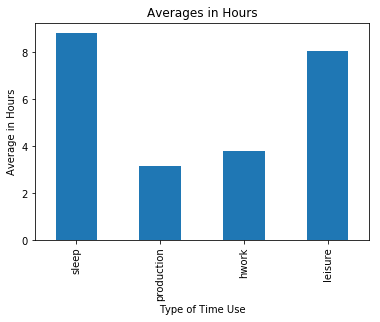

In [12]:
timevarnames = ['sleep', 'production', 'hwork', 'leisure']
timevarlist = [sleep, production, hwork, leisure]
avglist = [np.mean(sleep)/60, np.mean(production)/60, np.mean(hwork)/60, np.mean(leisure)/60]
avglist = pd.DataFrame(data = avglist, index = timevarnames, columns=['Total'])
ax = avglist.plot(kind='bar', title='Averages in Hours', legend=False, sort_columns=True)
ax.set_xlabel('Type of Time Use')
ax.set_ylabel('Average in Hours')

These are overall averages. Let's look at averages by month over the business cycle.

In [13]:
data['uniqueID'] = data['tuyear'].astype(str) + "-" + data['tumonth'].astype(str) #unique identifier for means
data['uniqueID']=pd.to_datetime(data['uniqueID'], format = '%Y-%m')#.apply(lambda x: x.strftime('%B-%Y'))  
for i in range(0,4):
    data[timevarnames[i]] = timevarlist[i] #Add in the totaled time variables to the original dataset
tusebymonth = pd.DataFrame(data = data[timevarnames])
tusebymonth['uniqueID'] = data['uniqueID']
tusebymonth.head()
averages = tusebymonth.groupby('uniqueID', axis=0).mean()
data.drop(timevarnames, axis=1, inplace=True)
data.drop(['uniqueID'], axis=1, inplace=True)

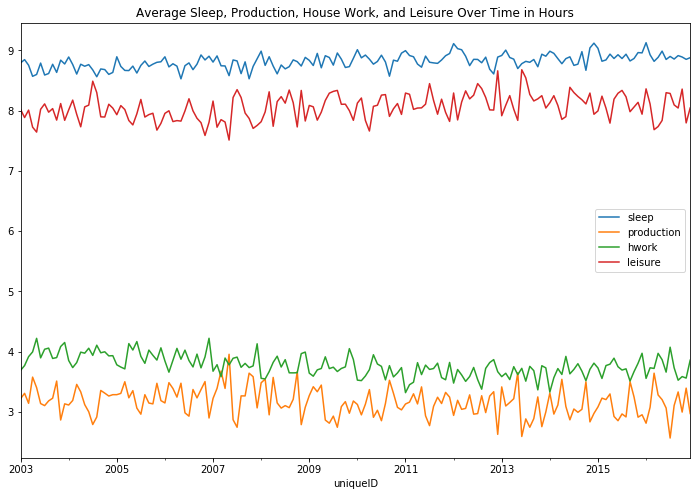

In [14]:
(averages/60).plot(figsize=(12,8),title=('Average Sleep, Production, House Work, and Leisure Over Time in Hours'))

In [15]:
averages['sleepMA'] = averages['sleep'].rolling(window=6).mean()

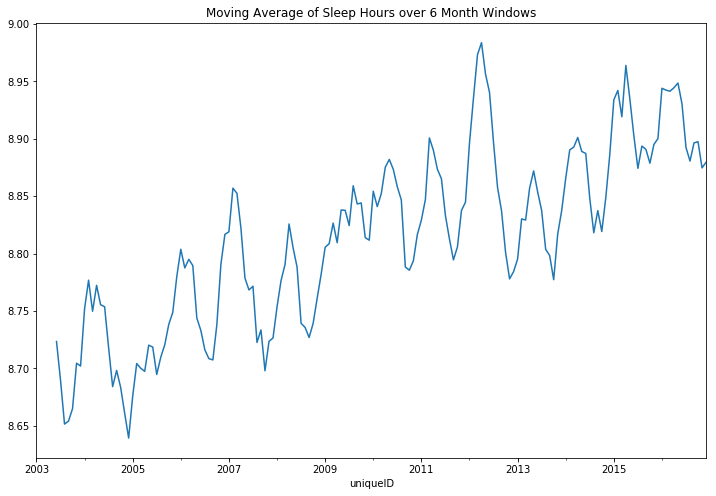

In [16]:
(averages['sleepMA']/60).plot(figsize=(12,8), title='Moving Average of Sleep Hours over 6 Month Windows')

I will now add in data with the unemployment rate for each of these months

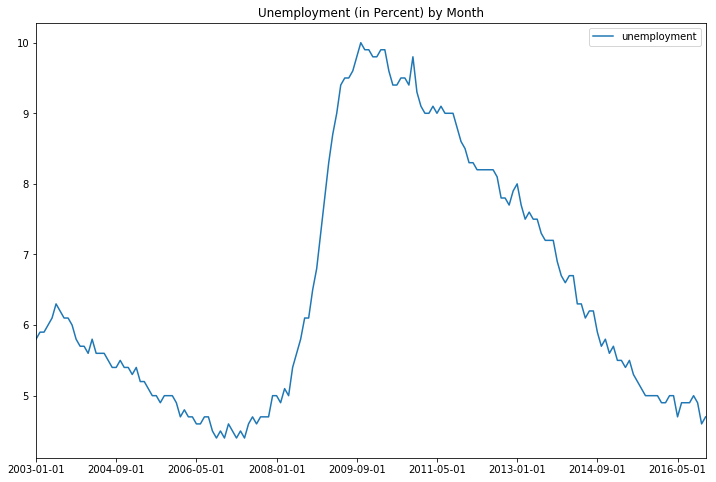

In [17]:
unemp = pd.read_csv('unemployment.csv',index_col='Unnamed: 0')
averages['unemployment']=unemp['unemployment']
unemp.plot(figsize=(12,8), title='Unemployment (in Percent) by Month')

We see some interesting patterns in correlations below

As we would expect, when unemployment increases, production falls.

However, we also see that leasure and sleep increase, and housework falls.

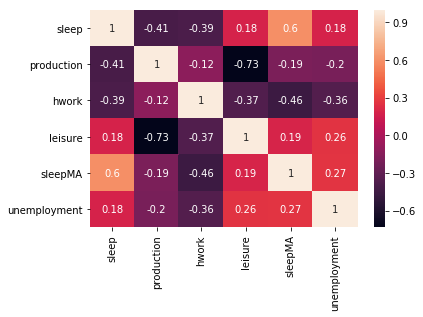

In [18]:
sns.heatmap(averages.corr(),annot=True)

# Predicting Sleep Using Linear Regression
- Preliminary feature selection. We just have a ton of features in our model
- We will predict sleep using a simple linear regression model
- We will examine which features have the highest predictive power (on our regularized data)
- We will take time subsets to see if these important sleep drivers change over time (around the recession)

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

To get the number of features down to a reasonable 240 we will drop the 800 with the weakest correlation to sleep

It takes a little time to calculate the correlations because it is creating a 1020x1020 correlation matrix. 

In [20]:
data_reg=data.copy()
data_reg['sleep']=sleep
corr = data_reg.corr()['sleep']
select = np.abs(corr).to_frame().sort_values(by='sleep').head(800)

In [21]:
drop_list=[]
for feat in select.index:
    drop_list = drop_list + [feat]
data_reg=data_reg.drop(drop_list,axis=1)    
data_reg = data_reg.drop(['sleep'], axis=1)

Split into Train and Test Sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data_reg, sleep, test_size=0.33, random_state=42)

Scale Our Data

In [23]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Use Training Set to search for the best learning rate using GridSearchCV

In [24]:
param_dist = {"eta0": [ .00005, .0001, .0003, .0007, .001, .005, .01]}
linear_regression_model = SGDRegressor(tol=.0001)
n_iter_search = 8
random_search = GridSearchCV(linear_regression_model,param_grid=param_dist, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_train, y_train)
print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.0001}
Best Negative MSE: -16468.234544622414


Fit our model with that learning rate

It seems like our model is doing pretty well. The lower MSE on the test set at least indicates that we don't have an overfitting problem. 

In [25]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.0003)
linear_regression_model.fit(X_train, y_train)

train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 16412.024768586605
Test MSE: 16036.945655861324


The most significant coefficients all involve the day of the week

In [26]:
coef=pd.DataFrame(data=linear_regression_model.coef_,index=data_reg.columns)
coef.columns = ['coef']
coef['abs_coef']=np.abs(coef['coef'])
coef = coef.sort_values(by='abs_coef')
coef['coef'].tail(5) 

tudiaryday_Monday      -19.250426
tudiaryday_Tuesday     -20.253303
tudiaryday_Wednesday   -20.378190
tudiaryday_Thursday    -20.602642
tudiaryday_Friday      -23.546306
Name: coef, dtype: float64

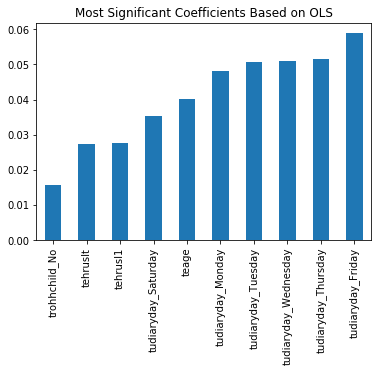

In [27]:
coef['scaled_coef'] = coef['abs_coef']/coef['abs_coef'].sum()
coef['scaled_coef'].tail(10).plot(kind='bar', title = 'Most Significant Coefficients Based on OLS')

#### Splitting Data into different date ranges
- We want to look at if sleep predictors change because of the 2008 financial crisis
- we will split our data into two subsets, pre-2008 and post-2008
- we can compare the significant features between the sets

In [28]:
data_reg['sleep'] = sleep
pre_crisis = data_reg.copy().query('tuyear < 2008')
post_crisis = data_reg.copy().query('tuyear > 2008')


In [29]:
pre_crisis_target = pre_crisis.sleep
pre_crisis.drop(['sleep'],axis=1,inplace=True)

post_crisis_target = post_crisis.sleep
post_crisis.drop(['sleep'],axis=1,inplace=True)

data_reg.drop(['sleep'],axis=1,inplace=True)

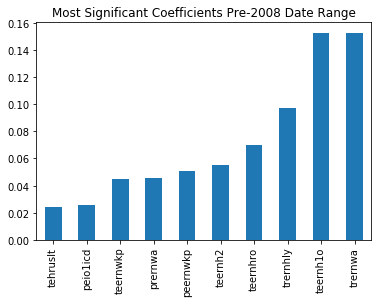

In [30]:
linear_regression_model.fit(pre_crisis, pre_crisis_target)
coef=pd.DataFrame(data=linear_regression_model.coef_,index=pre_crisis.columns)
coef.columns = ['coef']
coef['abs_coef']=np.abs(coef['coef'])
coef = coef.sort_values(by='abs_coef')
coef['scaled_coef'] = coef['abs_coef']/coef['abs_coef'].sum()
coef['scaled_coef'].tail(10).plot(kind='bar', title = 'Most Significant Coefficients Pre-2008 Date Range')

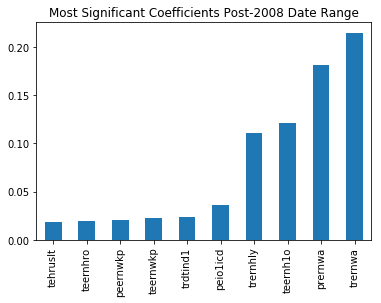

In [31]:
linear_regression_model.fit(post_crisis, post_crisis_target)
coef=pd.DataFrame(data=linear_regression_model.coef_,index=pre_crisis.columns)
coef.columns = ['coef']
coef['abs_coef']=np.abs(coef['coef'])
coef = coef.sort_values(by='abs_coef')
coef['scaled_coef'] = coef['abs_coef']/coef['abs_coef'].sum()
coef['scaled_coef'].tail(10).plot(kind='bar', title = 'Most Significant Coefficients Post-2008 Date Range')

We see that the predictors of sleep seem to change significantly before and after the financial crisis. Now we can look at doing some feature selection using ElasticNetCV

In [32]:
from sklearn.linear_model import ElasticNetCV
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.5, 1, 10], max_iter=10000)
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
opt_alpha = clf.alpha_
opt_l1 = clf.l1_ratio_
print("Optimal Alpha: {}".format(opt_alpha))
print("Optimal L1 Ratio: {}".format(opt_l1))
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Optimal Alpha: 0.5
Optimal L1 Ratio: 1.0
Train MSE: 16450.20784638298
Test MSE: 16065.057098640653


In [33]:
reg_coef=pd.DataFrame(data=clf.coef_,index=data_reg.columns)
reg_coef.columns = ['param']

We see that the day of the week (relative to Sunday) has a significant negative impact on the amount of sleep

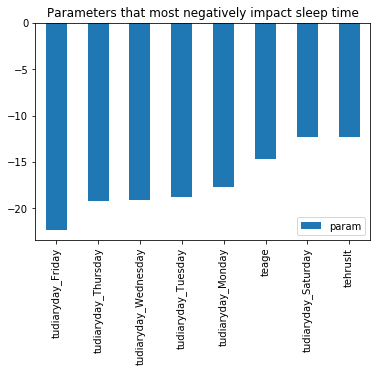

In [34]:
reg_coef.sort_values(by='param').head(8).plot(kind='bar', title="Parameters that most negatively impact sleep time")

Not having a child, or the day being a holiday has the largest positive impact on the amount of sleep

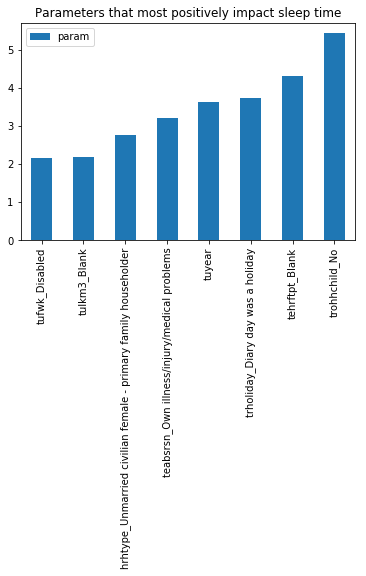

In [35]:
reg_coef.sort_values(by='param').tail(8).plot(kind='bar', title="Parameters that most positively impact sleep time")

We can once again seperate based on the date to see if anything changes

In [36]:
clf = ElasticNetCV(l1_ratio=opt_l1, alphas=[opt_alpha], max_iter=10000)
clf.fit(pre_crisis,pre_crisis_target)

ElasticNetCV(alphas=[0.5], copy_X=True, cv=None, eps=0.001,
       fit_intercept=True, l1_ratio=1.0, max_iter=10000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

The Most significant positive and negative coefficiants for the Pre-2008 ElasticNet Model

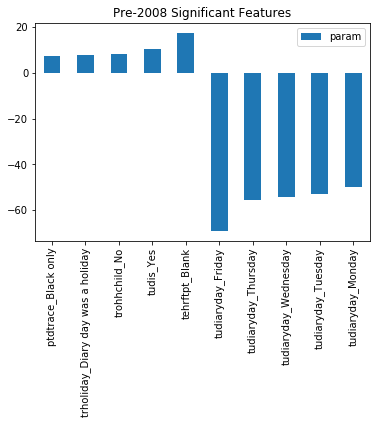

In [37]:
pre_coef=pd.DataFrame(data=clf.coef_,index=pre_crisis.columns)
pre_coef.columns = ['param']
pre_coef = pre_coef.sort_values(by='param')
pre_coef.tail(5).append(pre_coef.head(5)).plot(kind='bar',title="Pre-2008 Significant Features")

ElasticNetCV has a harder time on the post 2008 sample. We increase the maximum number of iterations here to help with some convergence problems. We see that the positive and negative significant features are identical in the pre and post 2008 samples in our ElasticNet model. 

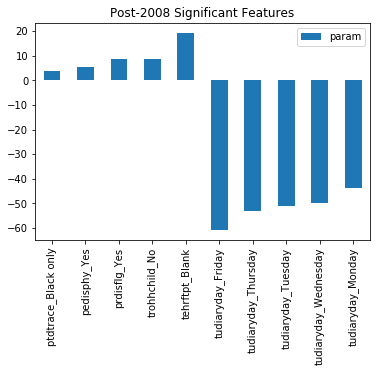

In [38]:
clf = ElasticNetCV(l1_ratio=opt_l1, alphas=[opt_alpha], max_iter=500000)
clf.fit(post_crisis,post_crisis_target)
post_coef=pd.DataFrame(data=clf.coef_,index=pre_crisis.columns)
post_coef.columns = ['param']
post_coef = post_coef.sort_values(by='param')
post_coef.tail(5).append(post_coef.head(5)).plot(kind='bar',title='Post-2008 Significant Features')

We can narrow down our sample even further by taking the 20 most significant factors out of elasticNet. ElasticNet drives non significant factors down to zero. We can then try our linear regression model again, and then try introducing polynomial features. 

In [39]:
feature=np.abs(reg_coef).sort_values(by='param').head(220)
data_poly = data_reg.copy()
drop_list=[]
for feat in feature.index:
    drop_list = drop_list + [feat]
data_poly=data_poly.drop(drop_list,axis=1)    

We've now narrowed down our data set from over 1000 variables to 20

In [40]:
data_poly.shape

(181335, 20)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data_poly, sleep, test_size=0.33, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We see that a regular linear regression model doesn't do quite as well with only 20 variables, but it isn't that much worse, and we've eliminated 220 variables. 

In [42]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.0003)
linear_regression_model.fit(X_train, y_train)

train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 16658.865541914223
Test MSE: 16271.67808921254


#### Polynomial Features

In [43]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, include_bias=False)
poly_df = poly.fit_transform(X_train)
poly_test = poly.fit_transform(X_test)
scaled_poly_df = scaler.fit_transform(poly_df)
scaled_poly_test = scaler.fit_transform(poly_test)

We see our 20 features become 230 features

In [44]:
scaled_poly_df.shape

(121494, 230)

We see that the training and testing MSE are better than any of the previous models. 

In [45]:
linear_regression_model.fit(scaled_poly_df, y_train)
train_predictions = linear_regression_model.predict(scaled_poly_df)
test_predictions = linear_regression_model.predict(scaled_poly_test)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test,test_predictions)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 16318.722513380597
Test MSE: 15956.180446513818


# Predicting Sleep, Random Forest

To find the correct hyperparameters, we will use only a subset of the data because of the large size of the data. With a 20,000 observation subset, it still takes several hours for cross-validation. The variable 'sdata' represents this subset.

In [46]:
data['sleep'] = sleep
sdata = data.sample(20000, axis = 0)
ssleep = sdata['sleep']
sdata.drop(['sleep'], axis=1, inplace=True)
data.drop(['sleep'], axis=1, inplace=True)

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
targetm1 = ssleep
X_train, X_test, y_train, y_test = train_test_split(sdata, targetm1, test_size=0.20, random_state=42)

In [49]:
param_dist = {"n_estimators": [100], "max_depth": [50, 75, 100], "max_features": [250, 500, 1000],
               "min_impurity_decrease": [.05, .1, .15], "max_leaf_nodes": [50, 75, 100], 
               "bootstrap": ['True']}
rfregressor = RandomForestRegressor()
rfgridsearch = GridSearchCV(rfregressor, param_grid=param_dist, scoring='neg_mean_squared_error', n_jobs=-1)
rfgridsearch.fit(X_train, y_train)
best_params=rfgridsearch.best_params_

In [59]:
print(best_params)

{'bootstrap': 'True', 'max_depth': 100, 'max_features': 1000, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.15, 'n_estimators': 100}


These parameter choices are not surprising. It is tempting to want to raise the maximum depth and maximum leaf nodes, but we see later on that we may be at risk of overfitting. Again, because of computational complexity, we have had to limit ourseles on the number of estimators.

In [50]:
rf1reg = RandomForestRegressor(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'],
                              max_features= best_params['max_features'], min_impurity_decrease = best_params['min_impurity_decrease'],
                              max_leaf_nodes = best_params['max_leaf_nodes'], bootstrap = best_params['bootstrap'], n_jobs=-1)
rf1reg.fit(X_train, y_train)
train_predictions = rf1reg.predict(X_train)
test_predictions = rf1reg.predict(X_test)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test,test_predictions)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 14255.571368024215
Test MSE: 16427.835293919165


Our test MSE is higher than the training MSE. We may be overfitting on the training set. This is may be a product of training on only a subset of the total data, which is an unfortunate necessity. Otherwise, we may wish to lower the number of estimators or the maximum depth of the tree.

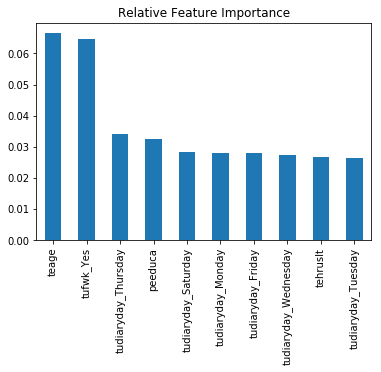

In [51]:
feature_imp = sorted(list(zip(data.columns, rf1reg.feature_importances_)), key=lambda x: x[1], reverse=True)
allfeatureimp = pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp])
allfeatureimp[0:10].plot(kind='bar', title='Relative Feature Importance')

The ranking of importance is comparable to the ranking in linear regression. We discuss this in the conclusion.

We now will examine how these predictive factors were different pre-2008 versus post-2008. The following function will streamline this.

In [52]:
def targetpredict(data, target, best_params):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=42)
    rfreg = RandomForestRegressor(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'],
                                  max_features= best_params['max_features'], min_impurity_decrease = best_params['min_impurity_decrease'],
                                  max_leaf_nodes = best_params['max_leaf_nodes'], bootstrap = best_params['bootstrap'], n_jobs=-1)
    rfreg.fit(X_train, y_train)
    feature_imp = sorted(list(zip(data.columns, rfreg.feature_importances_)), key=lambda x: x[1], reverse=True)
    allfeatureimp = pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp])
    train_predictions = rfreg.predict(X_train)
    test_predictions = rfreg.predict(X_test)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test,test_predictions)
    return allfeatureimp[0:10], train_mse, test_mse

We now split the data according to pre-crisis and post-crisis:

In [53]:
data['sleep'] = sleep
pre_crisis = data.copy().query('tuyear < 2008')
post_crisis = data.copy().query('tuyear > 2008')
pre_crisis_target = pre_crisis.sleep
pre_crisis.drop(['sleep'],axis=1,inplace=True)
post_crisis_target = post_crisis.sleep
post_crisis.drop(['sleep'],axis=1,inplace=True)

Train MSE: 15065.671338983337
Test MSE: 15835.553099130528


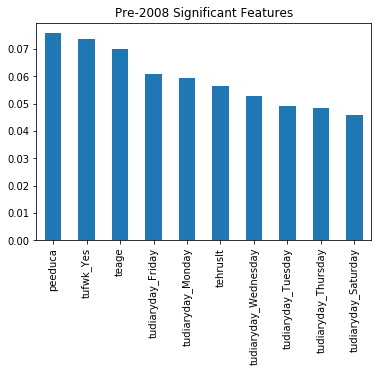

In [54]:
featureimp, train_mse, test_mse = targetpredict(pre_crisis, pre_crisis_target, best_params)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))
featureimp.plot(kind='bar',title='Pre-2008 Significant Features')

Train MSE: 15751.36900640957
Test MSE: 16490.60157491638


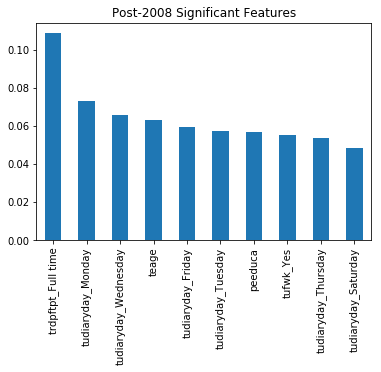

In [55]:
featureimp, train_mse, test_mse = targetpredict(post_crisis, post_crisis_target, best_params)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))
featureimp.plot(kind='bar',title='Post-2008 Significant Features')

The important features are different pre-2008 vs. post-2008. We discuss these differences in the conclusion.

## Other Predictions

We now will attempt to predict housework, production, and leisure, just exploratorily. We use the random forest algorithm to get a simple idea of what is going on. We also examine relative feature importance.

In [60]:
data.drop(['sleep'], axis=1, inplace=True)

Train MSE: 28261.138836084287
Test MSE: 28520.587477018667


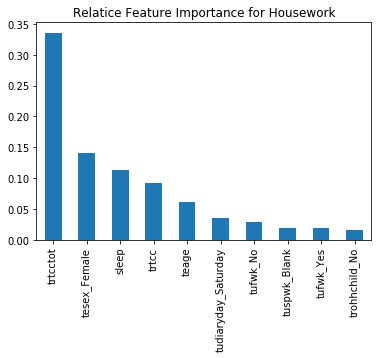

In [56]:
featureimp, train_mse, test_mse = targetpredict(data, hwork, best_params)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))
featureimp.plot(kind='bar',title='Relatice Feature Importance for Housework')

Train MSE: 25515.504067973376
Test MSE: 25875.78894000768


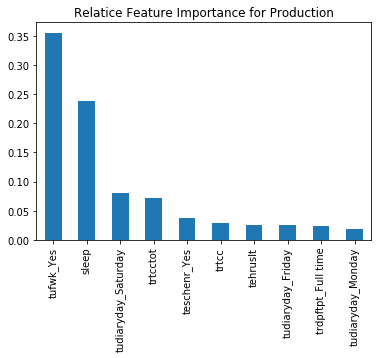

In [57]:
featureimp, train_mse, test_mse = targetpredict(data, production, best_params)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))
featureimp.plot(kind='bar',title='Relatice Feature Importance for Production')

Train MSE: 33570.34299875007
Test MSE: 33649.47111510731


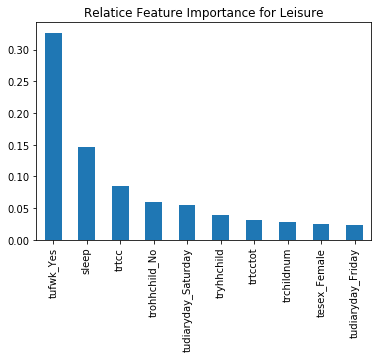

In [58]:
featureimp, train_mse, test_mse = targetpredict(data, leisure, best_params)
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))
featureimp.plot(kind='bar',title='Relatice Feature Importance for Leisure')

What do we learn about these feature importances? Unfortunately, very little. Varying the hyper parameters and subset of the data used for training leads to quite different results. We lack statistical power here as well.

# Conclusion
So, what have we learned about predicting sleep?

It seems that the demographic information that we have is not that great of a predictor for time use. Our MSE was high no matter the model we used.

It also seems that we lack evidence for there being a significant change in factors related to sleep during the financial crisis of 2008. We find that the features are different in our analyses, but these differences have not shown themselves to be robust given relatively small changes in hyperparameters. Therefore, we fail to conlcude that there is a difference.

One limiting factor here was computational power. Random forests are often great estimators, but we were limited to train them using a rather small subset of the data, and they ended up being one of the worst predictors.

Even though our analysis failed to find anything interesting, there are still plenty of areas that ought to be explored. Only a cursory foray was made into predicting housework, production, and leisure. Also, we did not attempt to use time use data to predict other time use variables. It may be of interest, for example, to see how specific leisure activities can be used to predict sleep, or vice versa.